In [1]:
using NBInclude
@nbinclude("functions.ipynb")
function load_model_identity(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder decoder_last
    println("Done")
    return encoder_μ, encoder_logvar, decoder, decoder_last
    
end

function load_model_sep(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar W1 W2 W3 Q
    println("Done")
    return encoder_μ, encoder_logvar, W1, W2, W3, Q
end

function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end



function get_test_loader(batch_size, shuffle::Bool)
    # The FashionMNIST test set is made up of 10k 28 by 28 greyscale images
    test_x, test_y = MNIST.testdata(Float32)
    test_x = 1 .- reshape(test_x, (784, :))
    return DataLoader((test_x, test_y), batchsize=batch_size, shuffle=shuffle)
end

All function imported


get_test_loader (generic function with 1 method)

┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195


Loading model...Done
Loading model...Done


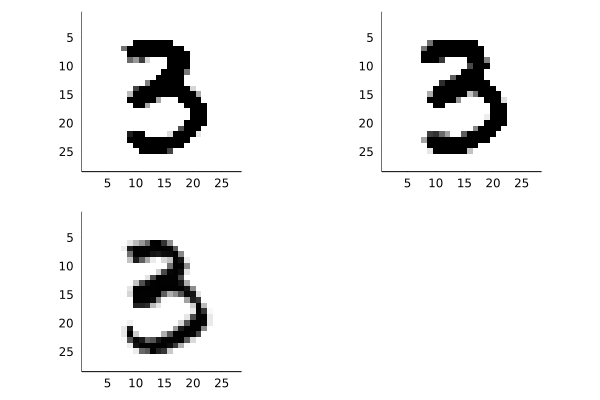

In [11]:
# pick a image in MNIST to denoise
num = 3
batch_size = 64
shuffle_data = true
dataloader = get_test_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end
x_true= x_batch[:,i];

# Load the model and test set loader incoherent
epoch_to_load_inco = 20
dir_inco = "trained_GNN/MNIST_identity_v2"
encoder_μ_inco, encoder_logvar_inco, W1_inco, W2_inco, W3_inco, Q_inco = load_model_sep(dir_inco, epoch_to_load_inco);

μ = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)

# Load the model and test set loader unenforced
epoch_to_load_co = 20
dir_co = "trained_GNN/MNIST_v3"
encoder_μ_co, encoder_logvar_co, W1_co, W2_co, W3_co, Q_co = load_model_sep(dir_co, epoch_to_load_co);

μ = encoder_μ_co(x_true)
logvar_co = encoder_logvar_co(x_true)
# Apply reparameterisation trick to sample latent
z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)

#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 5000; out_toggle = 0
opt = Flux.Optimise.ADAM(.1);

G_inco(z) =Q_inco *W3_inco*relu(W2_inco*relu(W1_inco*z))
G_co(z) = Q_co*relu(W2_co*relu(W1_co*z))

plot(plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' )), plot(colorview(Gray, reshape(G_co(z_co), 28,28)' )), plot(colorview(Gray, reshape(x_true, 28,28)' )) )

In [8]:
k = 20
m_list = [10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200, 250];
batch_size = 64
shuffle_data = true

z_co_list = zeros(9, k)
z_inco_list = zeros(9, k)
x_true_list = zeros(9, 784)
z_est_inco_matrix = zeros(9, k, length(m_list))
z_est_co_matrix = zeros(9, k, length(m_list))

Threads.@threads for num in 1:9
    dataloader = get_test_loader(batch_size, shuffle_data)
    (x_batch, y_batch) = first(dataloader)
    i = 1
    while y_batch[i] != num
    i += 1
    end
    x_true= x_batch[:, i];

    z_est_inco_list = zeros(k, length(m_list))
    z_est_co_list = zeros(k, length(m_list))
    x_true_list[num,:] = x_true

    # Apply reparameterisation trick to sample latent
    μ = encoder_μ_inco(x_true)
    logvar_inco = encoder_logvar_inco(x_true)
    z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)
    z_inco_list[num,:] = z_inco

    μ = encoder_μ_co(x_true)
    logvar_co = encoder_logvar_co(x_true)
    # Apply reparameterisation trick to sample latent
    z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)
    z_co_list[num,:] = z_co

     for i in 1:length(m_list)
        m = m_list[i]
        F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
        F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

        y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
        z_est_inco = randn(k) #initialization for algorithm
        z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        z_est_inco_list[:,i] = z_est_inco

        y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
        z_est_co = randn(k) #initialization for algorithm
        z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        z_est_co_list[:,i] = z_est_co
    end

    z_est_inco_matrix[num,:,:] = z_est_inco_list
    z_est_co_matrix[num,:,:] = z_est_co_list

end





┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/

┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195


In [10]:
save("saved_data/MNIST_image_recovery_20_v2.jld", "z_inco_list", z_inco_list, "z_co_list", z_co_list, "x_true_list", x_true_list, "z_est_inco_matrix", z_est_inco_matrix, "z_est_co_matrix", z_est_co_matrix, "epoch", 20, "m_list", m_list)

In [12]:
k = 20
m_list = [10, 15, 20, 25, 30, 35, 40, 45, 50, 100, 150, 200, 250];
batch_size = 6400
shuffle_data = true

trials = 20
recon_error_matrix_inco = zeros(length(m_list), trials)
recon_error_matrix_co = zeros(length(m_list), trials)

Threads.@threads for trials in 1:trials
    recon_error_list_inco = []
    recon_error_list_co = []

    for m in m_list
        num = rand(1:9)
        dataloader = get_test_loader(batch_size, shuffle_data)
        (x_batch, y_batch) = first(dataloader)
        i = 1
        while y_batch[i] != num
            i += 1
        end
        x_true= x_batch[:, i];
    
        # Apply reparameterisation trick to sample latent
        μ = encoder_μ_inco(x_true)
        logvar_inco = encoder_logvar_inco(x_true)
        z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)
    
        # Apply reparameterisation trick to sample latent
        μ = encoder_μ_co(x_true)
        logvar_co = encoder_logvar_co(x_true)
        z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)
        
        F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
        F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

        y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
        z_est_inco = randn(k) #initialization for algorithm
        z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        push!(recon_error_list_inco, relative_error(G_inco(z_inco), G_inco(z_est_inco)))

        y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
        z_est_co = randn(k) #initialization for algorithm
        z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
        push!(recon_error_list_co, relative_error(G_co(z_co), G_co(z_est_co)))

    end
    recon_error_matrix_inco[:, trials] = recon_error_list_inco
    recon_error_matrix_co[:, trials] = recon_error_list_co

end





┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/

┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/

┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/

In [21]:



log_recon_error_matrix_co = log10.(recon_error_matrix_co[:, :])
average_recon_co = mean(log_recon_error_matrix_co, dims=2)
std_recon_co = std(log_recon_error_matrix_co, dims=2)
plot(m_list, average_recon_co + std_recon_co, fillrange = average_recon_co - std_recon_co, fillalpha = .2, c = cs[40], label = false, linecolor = invisible())
scatter!(kron(m_list,ones(1,trials))[:], log_recon_error_matrix_co[:], label =:false, c = cs[100], markershape = :dtriangle, lab="high coherence", legendfontsize=10)
plot!(m_list, average_recon_co, linewidth = 2, color = cs[10], label =false, linestyle =:dash )
yticks = [-8:2:0;]
yticks!(yticks, [L"10^{%$y}" for y in yticks])

scatter!([1],[0], label=" ", ms=0, mc=:white, msc=:white)


log_recon_error_matrix_inco = log10.(recon_error_matrix_inco[:, :])
average_recon_inco = mean(log_recon_error_matrix_inco, dims=2)
std_recon_inco = std(log_recon_error_matrix_inco, dims=2)
plot!(m_list, average_recon_inco + std_recon_inco, fillrange = average_recon_inco - std_recon_inco, fillalpha = .2, c = cs[440], label = false, linecolor = invisible())
scatter!(kron(m_list,ones(1,trials))[:], log_recon_error_matrix_inco[:], label =:false, c = cs[500], lab="low coherence")
plot!(m_list, average_recon_inco, xlabel = "number of measurements", ylabel = "relative reconstruction error", linewidth = 2, color = cs[400], label =false,  xlabelfontsize = 15, ylabelfontsize = 15, xtickfontsize = 12, ytickfontsize = 12 )
# scatter!(m_list, average_recon_inco, label =:false, c = cs[500], markershape =:dtriangle)

# yticks = [-8:2:0;]
# yticks!(yticks, [L"10^{%$y}" for y in yticks])

savefig("figures/1_measurement.pdf")

In [49]:
log10.(recon_error_matrix_inco[:, :]) 

13×2 Matrix{Float64}:
 -0.26151  -0.269499
 -1.11674  -1.03212
 -0.25259  -2.15236
 -7.39224  -4.49172
 -7.50533  -4.82362
 -7.43568  -3.28155
 -7.5686   -3.5503
 -7.67517  -7.72668
 -7.68488  -7.70805
 -7.88682  -7.9208
 -7.87613  -7.94525
 -7.93131  -7.7154
 -7.93879  -8.19999

In [54]:
kron(m_list,ones(1,trials))

13×2 Matrix{Float64}:
  10.0   10.0
  15.0   15.0
  20.0   20.0
  25.0   25.0
  30.0   30.0
  35.0   35.0
  40.0   40.0
  45.0   45.0
  50.0   50.0
 100.0  100.0
 150.0  150.0
 200.0  200.0
 250.0  250.0

In [41]:
average_recon = mean(log_recon_error_matrix, dims=2)'


1×13 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.605253  -0.702284  -1.21735  -2.66436  …  -6.21182  -8.19465  -7.88352

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Babhru\.julia\packages\MLDatasets\Xb4Lh\src\datasets\vision\mnist.jl:187


Loading model...Done
Loading model...Done


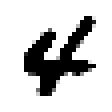

In [56]:


# pick a image in MNIST to denoise
num = 1
batch_size = 64
shuffle_data = true
dataloader = get_test_loader(batch_size, shuffle_data)

(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
    i += 1
end

x_true= x_batch[:,i];
# Load the model and test set loader incoherent
epoch_to_load_inco = 20
dir_inco = "trained_GNN/MNIST_identity_v2"
encoder_μ_inco, encoder_logvar_inco, decoder_inco, W3_inco = load_model_identity(dir_inco, epoch_to_load_inco);
μ = encoder_μ_inco(x_true)
logvar_inco = encoder_logvar_inco(x_true)
# Apply reparameterisation trick to sample latent
z_inco = μ + randn(Float32, size(logvar_inco)) .* exp.(0.5f0 * logvar_inco)


# Load the model and test set loader unenforced
epoch_to_load_co = 20
dir_co = "trained_GNN/MNIST_v2"
encoder_μ_co, encoder_logvar_co, decoder_co, W3_co = load_model_identity(dir_co, epoch_to_load_co);
μ = encoder_μ_co(x_true)
logvar_co = encoder_logvar_co(x_true)
# Apply reparameterisation trick to sample latent
z_co = μ + randn(Float32, size(logvar_co)) .* exp.(0.5f0 * logvar_co)


#setup
x_dim = 784
k = 20
tolerance = 1e-7; max_iter = 3000; out_toggle = 0
opt = Flux.Optimise.ADAM(.1);

G_inco(z) = W3_inco *decoder_inco(z)
G_co(z) = W3_co *decoder_co(z)
colorview(Gray, reshape(G_co(z_co), 28,28)' )




┌ Info: Saved animation to 
│   fn = c:\Users\Babhru\Documents\GitHub\GNN_Isometries\anim_4.gif
└ @ Plots C:\Users\Babhru\.julia\packages\Plots\E2187\src\animation.jl:126


Plots.AnimatedGif("c:\\Users\\Babhru\\Documents\\GitHub\\GNN_Isometries\\anim_4.gif")
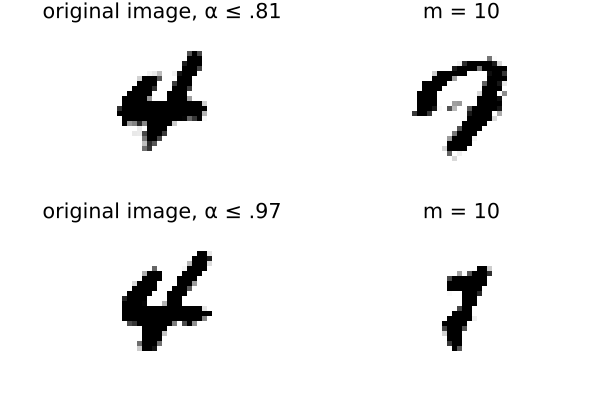

In [57]:
m_list = 10:5:100
z_est_inco_list = zeros(k, length(m_list))
z_est_co_list = zeros(k, length(m_list))

Threads.@threads for i in 1:length(m_list)
    m = m_list[i]
    F_sub = sample_fourier(m, x_dim)  # subsampling DCT for measurement matrix
    F_sub = F_sub * sqrt(x_dim)/sqrt(m); #normalization  

    y = F_sub * G_inco(z_inco) # measurement vector using subsampled DCT matrix
    z_est_inco = randn(k) #initialization for algorithm
    z_est_inco = estimated_code(opt, G_inco, y, F_sub, z_est_inco; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_inco_list[:,i] = z_est_inco

    y = F_sub * G_co(z_co) # measurement vector using subsampled DCT matrix
    z_est_co = randn(k) #initialization for algorithm
    z_est_co = estimated_code(opt, G_co, y, F_sub, z_est_co; max_iter, tolerance, out_toggle)  # run a optimizer to solve the least squares problem
    z_est_co_list[:,i] = z_est_co
end

anim = @animate for k ∈ 1:length(m_list)
    p1 = plot(colorview(Gray, reshape(G_inco(z_inco), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .81")
    p2 = plot(colorview(Gray, reshape(G_inco(z_est_inco_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    p3 = plot(colorview(Gray, reshape(G_co(z_co), 28,28)' ), framestyle = :none, bg =:black, title = "original image, α ≤ .97")
    p4 = plot(colorview(Gray, reshape(G_co(z_est_co_list[:, k]), 28,28)' ), framestyle = :none, bg =:black, title = "m = $(m_list[k])")

    plot(p1, p2, p3, p4, layout = grid(2,2))
end

gif(anim, "anim_$num.gif", fps = 1)



In [7]:
# batch_size =
dataloader = get_test_loader(batch_size, shuffle_data)
(x_batch, y_batch) = first(dataloader)
i = 1
while y_batch[i] != num
i += 1
end
x_true= x_batch[:, i];

┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets /Users/babhru/.julia/packages/MLDatasets/Xb4Lh/src/datasets/vision/mnist.jl:195


In [8]:
i

7

In [19]:
i +=1
while y_batch[i] != num
i += 1
end
x_true= x_batch[:, i];


In [20]:
i

30